In [1]:
# Imports
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, GlobalAveragePooling1D
from keras.layers import LSTM

# to enable local imports
module_path = os.path.abspath('../../code')
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)
    
from machine_learning_load_data import loadOnlineEEGdata

Using TensorFlow backend.


D:\Masterthesis\thesis_eeg\code


In [37]:
tf.__version__

'2.1.0'

In [3]:
keras.__version__

'2.2.4-tf'

In [69]:
# Load some online EEG Data
eegData, freqData, entropyData = loadOnlineEEGdata(dirPath='../../../EEG_Data/eeg_data_online', splitData=True)

X_train_eeg, y_train_eeg, X_test_eeg, y_test_eeg = eegData
X_train_freq, y_train_freq, X_test_freq, y_test_freq = freqData
X_train_entropy, y_train_entropy, X_test_entropy, y_test_entropy = entropyData

# reshape
X_train_freq = X_train_freq.reshape(X_train_freq.shape[0], X_train_freq.shape[2])
X_test_freq = X_test_freq.reshape(X_test_freq.shape[0], X_test_freq.shape[2])

X_train_entropy = X_train_entropy.reshape(X_train_entropy.shape[0], X_train_entropy.shape[2])
X_test_entropy = X_test_entropy.reshape(X_test_entropy.shape[0], X_test_entropy.shape[2])


##################
# experiment data
##################
eegData_exp, freqData_exp, entropyData_exp = loadOnlineEEGdata(dirPath='../../../EEG_Data/muse_data', splitData=True)

X_train_eeg_exp, y_train_eeg_exp, X_test_eeg_exp, y_test_eeg_exp = eegData_exp
X_train_freq_exp, y_train_freq_exp, X_test_freq_exp, y_test_freq_exp = freqData_exp
X_train_entropy_exp, y_train_entropy_exp, X_test_entropy_exp, y_test_entropy_exp = entropyData_exp

# reshape
X_train_freq_exp = X_train_freq_exp.reshape(X_train_freq_exp.shape[0], X_train_freq_exp.shape[2])
X_test_freq_exp = X_test_freq_exp.reshape(X_test_freq_exp.shape[0], X_test_freq_exp.shape[2])

X_train_entropy_exp = X_train_entropy_exp.reshape(X_train_entropy_exp.shape[0], X_train_entropy_exp.shape[2])
X_test_entropy_exp = X_test_entropy_exp.reshape(X_test_entropy_exp.shape[0], X_test_entropy_exp.shape[2])

#targetLabelsDict_exp = loadTargetLabelsTxt(filePath='../../EEG_Data/muse_data/target_labels.txt')
#targetNames_exp = ['AWAKE ({})'.format(targetLabelsDict_exp['AWAKE']),
#               'FATIGUE ({})'.format(targetLabelsDict_exp['FATIGUE'])]


Loading Online EEG Data from ../../../EEG_Data/eeg_data_online ...
EEG Data Shape:
(5024, 512, 40) (5024,) (2154, 512, 40) (2154,)
Freq Data Shape:
(1008, 1, 1200) (1008,) (432, 1, 1200) (432,)
Entropy Data Shape:
(5024, 1, 200) (5024,) (2154, 1, 200) (2154,)
Loading Online EEG Data from ../../../EEG_Data/muse_data ...
EEG Data Shape:
(5393, 512, 4) (5393,) (2312, 512, 4) (2312,)
Freq Data Shape:
(1084, 1, 120) (1084,) (465, 1, 120) (465,)
Entropy Data Shape:
(5393, 1, 20) (5393,) (2312, 1, 20) (2312,)


NameError: name 'loadTargetLabelsTxt' is not defined

In [16]:
def TrainEvaluateNet(x_train, y_train, x_test, y_test):

    #Convert data set to numpy array of type float32
    #x_train = np.asarray(x_train, np.float32)
    #y_train = np.asarray(y_train, np.float32)
    #x_test = np.asarray(x_test, np.float32)
    #y_test = np.asarray(y_test, np.float32)

    #Number of neurons
    neurons_num = int((2/3) * x_train.shape[2])

    #Initialize neural net
    #output of layer = keras.layers.Dense(number of neurons, activation function, name)(input of layer)
    inputs = keras.Input(shape=(x_train.shape[1], x_train.shape[2]), name='input_points')
    x = keras.layers.Dense(neurons_num, activation='relu', name='L1')(inputs)
    x = keras.layers.Dense(neurons_num, activation='relu', name='L2')(x)
    outputs = keras.layers.Dense(2, activation='softmax', name='output_point')(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name='fatigue_classifier')

    #Set optimizer, loss function and metrics to track
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    #binary_crossentropy

    #Summary of the neural net
    #model.summary()
    
    #Train neural net
    model.fit(x_train, y_train, epochs=3)

    #Evaluate neural net
    score = model.evaluate(x_test, y_test, verbose=verbose)
    loss = score[0]
    accuracy = score[1]
    print('Test loss:', loss)
    print('Test accuracy:', accuracy)
    return (model, loss, accuracy)


In [27]:
def trainEvaluateNet(x_train, y_train, x_test, y_test,batch_size=64, num_classes=2, epochs=5, verbose=0):

    #Settings
    neurons_num = int((2/3) * x_train.shape[2]) #Number of neurons

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    #Initialize neural net
    model = Sequential()
    model.add(Conv1D(32, kernel_size=10, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Conv1D(64, kernel_size=1, activation='relu'))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(neurons_num, activation='relu'))
    model.add(Dense(neurons_num, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax', name='last_dense')) 

    model.summary()
    
    #Set optimizer, loss function and metrics to track
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(0.01), metrics=['accuracy'])
    #model.compile(loss=keras.losses.squared_hinge, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])

    #Summary of the neural net
    #model.summary()
    
    #Train neural net
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=verbose,
              validation_data=(x_test, y_test))
    #         validation_split=0.2)

    #Evaluate neural net
    score = model.evaluate(x_test, y_test, verbose=verbose)
    loss = score[0]
    accuracy = score[1]
    print('Test loss: {}'.format(loss))
    print('Test accuracy: {}'.format(accuracy))
    return (model, loss, accuracy)

    #Predict best route
    return model

In [48]:
def trainEasyNet(x_train, y_train, x_test, y_test, batch_size=64, num_classes=2, epochs=5, verbose=0):
    
    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    
    neurons_num = int((2/3) * x_train.shape[1]) #Number of neurons
    
    # define the keras model
    model = Sequential()
    model.add(Dense(int(neurons_num*2), input_dim=x_train.shape[1], activation='relu'))
    model.add(Dense(neurons_num, activation='relu'))
    #model.add(GlobalAveragePooling1D())
    model.add(Dense(int(neurons_num/2), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax', name='last_dense'))
    
    #model.summary()
    
    # compile the keras model
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(0.01), metrics=['accuracy'])
    # fit the keras model on the dataset
    
    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
    
    #Evaluate neural net
    score = model.evaluate(x_test, y_test, verbose=verbose, batch_size=batch_size)
    loss = score[0]
    accuracy = score[1]
    #print('Test loss: {}'.format(loss))
    #print('Test accuracy: {}'.format(accuracy))
    return (model, loss, accuracy)


In [74]:
# fit and evaluate a model
def train_lstm(x_train, y_train, x_test, y_test, batch_size=64, num_classes=2, epochs=5, verbose=0):
    
    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    
    try:
        n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train.shape[1]
    except IndexError: 
        # reshape that...
        x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
        x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
        n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train.shape[1]

    
    
    #print("n_timesteps: {} - n_features: {} - n_outputs: {}".format(n_timesteps, n_features, n_outputs))
    model = Sequential()
    
    model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.3))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
    
    #Evaluate neural net
    score = model.evaluate(x_test, y_test, verbose=verbose, batch_size=batch_size)
    loss = score[0]
    accuracy = score[1]
    #print('Test loss: {}'.format(loss))
    #print('Test accuracy: {}'.format(accuracy))
    return (model, loss, accuracy)

def train_cnn(x_train, y_train, x_test, y_test, batch_size=64, num_classes=2, epochs=5, verbose=0):
    
    if len(x_train.shape) < 3:
        x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
        x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
    
    # Create the network
    model = Sequential()
    model.add(Conv1D(40, 10, strides=2, padding='same', activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dropout(0.2))
    #model.add(MaxPooling1D(1))
    model.add(Conv1D(40, 5, strides=2, padding='same', activation='relu'))
    model.add(Dropout(0.2))
    #model.add(MaxPooling1D(1))
    model.add(Conv1D(40, 4, strides=1, padding='same', activation='relu'))
    model.add(Dropout(0.2))
    #model.add(MaxPooling1D(1))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='relu'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    # Train and save results for later plotting
    #history[ '40 1023 523 413 50 :'+'-'.join(selected)] = model.fit(x_train, y_train, 
    #    batch_size=100, epochs=40, validation_data=(x_val,y_val))
    
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
    
    #print("History: {}".format(history))
    
    #Evaluate neural net
    score = model.evaluate(x_test, y_test, verbose=verbose, batch_size=batch_size)
    loss = score[0]
    accuracy = score[1]
    #print('Test loss: {}'.format(loss))
    #print('Test accuracy: {}'.format(accuracy))
    return (model, loss, accuracy, history)
    
    
    

In [7]:
def ApplyNet(input_data, model):
    prediction = model.predict([input_data]) 
    return prediction

In [28]:
def plot_metrcis(statistics_data, title:str, metric:str = 'accuarcy'):
    
    # Define labels, positions, bar heights and error bar heights
    x_pos = np.arange(len(statistics_data.keys()))
    
    # Define labels, positions, bar heights and error bar heights
    model_names = statistics_data.keys()
    
    plot_data_dict = {}

    for model in statsDict.keys():
        for data_source_key in statsDict[model].keys():
            try:
                plot_data_dict[data_source_key].append(statsDict[model][data_source_key][metric])
            except KeyError:
                plot_data_dict[data_source_key] = []
                plot_data_dict[data_source_key].append(statsDict[model][data_source_key][metric])

        
    
    # create plot
    width = 0.2    
    fig, ax = plt.subplots(figsize=(12,5))
    
    counter = 0
    for label, data in plot_data_dict.items():
        plt.bar(x_pos + width*counter, data, width, label=label)
        counter += 1
    
    
    ax.set_ylabel(metric)
    ax.set_xticks(x_pos + width)
    ax.set_xticklabels(model_names)
    ax.set_title(title)
    ax.yaxis.grid(True)
    
    
    ax.set_ylim(0, 1)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
    plt.legend(loc='best')
    # Save the figure and show
    #save_fig("{}_metrics".format(title.replace(" ", "_")))
    plt.show()

Evaluating CNN...
Epoch 1/50
1008/1008 [==============================] - 1s 1ms/step - loss: 2.2697 - accuracy: 0.5238
Epoch 2/50
1008/1008 [==============================] - 0s 372us/step - loss: 0.8010 - accuracy: 0.5069
Epoch 3/50
1008/1008 [==============================] - 0s 413us/step - loss: 0.7476 - accuracy: 0.5526
Epoch 4/50
1008/1008 [==============================] - 0s 428us/step - loss: 0.7419 - accuracy: 0.5258
Epoch 5/50
1008/1008 [==============================] - 0s 389us/step - loss: 0.7283 - accuracy: 0.5377
Epoch 6/50
1008/1008 [==============================] - 0s 379us/step - loss: 0.7287 - accuracy: 0.5258
Epoch 7/50
1008/1008 [==============================] - 0s 422us/step - loss: 0.7067 - accuracy: 0.5357
Epoch 8/50
1008/1008 [==============================] - 0s 413us/step - loss: 0.6838 - accuracy: 0.5605
Epoch 9/50
1008/1008 [==============================] - 0s 393us/step - loss: 0.6791 - accuracy: 0.5794
Epoch 10/50
1008/1008 [=========================

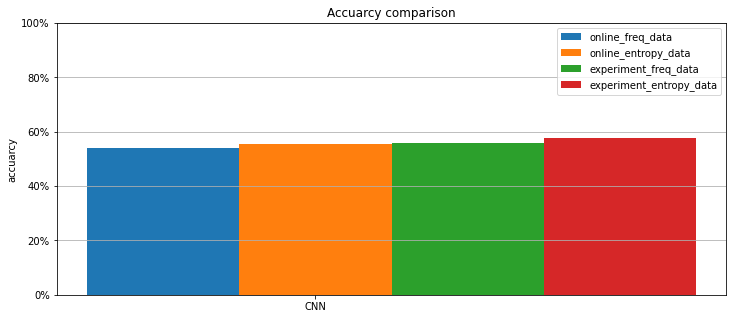

In [83]:
netFunctionList = [ #("Easy Net", trainEasyNet)];
                   ("CNN", train_cnn)]
                   #("LSTM Net", train_lstm)]

epochs = 50
batch_size = 64
verbose = 0
num_classes = 2

statsDict = {}

for net_name, function in netFunctionList:
    print("Evaluating {}...".format(net_name))
    
    statsDict[net_name] = {}
    
    #print("Online Frequency Data")
    model, loss, accuarcy, history = function(X_train_freq, y_train_freq, X_test_freq, y_test_freq,
                                     epochs=epochs, batch_size=batch_size, verbose=verbose)
    statsDict[net_name]['online_freq_data'] = {"model" : model, "loss" : loss, "accuarcy" : accuarcy, "history": history}
    
    #print("Online Entropy Data")
    model, loss, accuarcy, history = function(X_train_entropy, y_train_entropy, X_test_entropy, y_test_entropy,
                                     epochs=epochs, batch_size=batch_size, verbose=verbose)
    statsDict[net_name]['online_entropy_data'] = {"model" : model, "loss" : loss, "accuarcy" : accuarcy, "history": history}
    
    #print("Experiement Frequency Data")
    model, loss, accuarcy, history = function(X_train_freq_exp, y_train_freq_exp, X_test_freq_exp, y_test_freq_exp,
                                     epochs=epochs, batch_size=batch_size, verbose=verbose)
    statsDict[net_name]['experiment_freq_data'] = {"model" : model, "loss" : loss, "accuarcy" : accuarcy, "history": history}
    
    #print("Experiement Entropy Data")
    model, loss, accuarcy, history = function(X_train_entropy_exp, y_train_entropy_exp, X_test_entropy_exp, y_test_entropy_exp,
                                     epochs=epochs, batch_size=batch_size, verbose=verbose)
    statsDict[net_name]['experiment_entropy_data'] = {"model" : model, "loss" : loss, "accuarcy" : accuarcy, "history": history}

print("Done")
plot_metrcis(statsDict, title="Accuarcy comparison")

[Text(0, 0.5, 'Acc'), Text(0.5, 0, 'Epoch')]

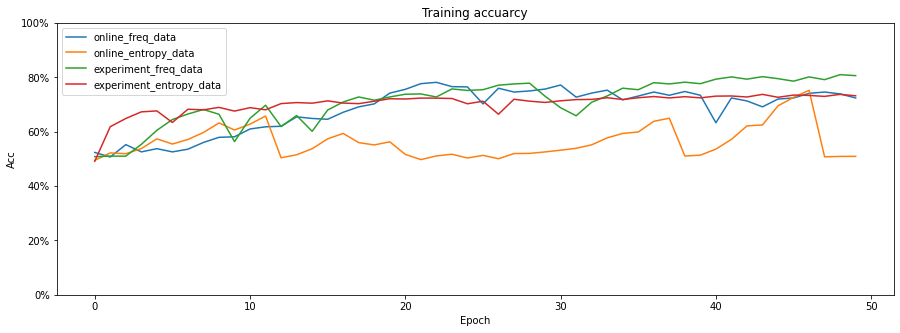

In [87]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title('Training accuarcy')

for model in statsDict:
    for data_source in statsDict[model]:
        ax.plot(statsDict[model][data_source]['history'].history['accuracy'], label=data_source)

plt.legend(loc="upper left")
ax.set_ylim(0, 1)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.set(xlabel='Epoch', ylabel='Acc')